# 3. The First Look

Before we dive into testing our hypothesis, let's try to familiarize a bit more with the collected data.
We start by loading the created dataset.

In [1]:
import pickle
import calendar
import numpy as np
import matplotlib.pyplot as plt

# import data
with open("../data/all_data.pkl","rb") as datafile:
    data = pickle.load(datafile)
    
# some settings to center plots
from IPython.core.display import HTML
HTML("""<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>""")

## 3.1 Total Burned Area in Sardinia
If we sum up the burned area for all gridcells we can visualize the amount of monthly burned area in Sardinia for the past 10 years.

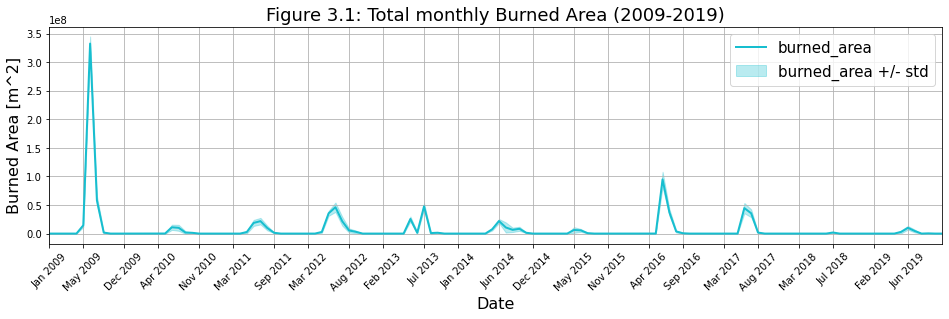

In [2]:
# lets calculate the monthly and yearly bins of the whole island
n_time = data["idx"].shape[0]
monthly_burned_area = np.asarray([np.sum(data["burned_area"][i, :, :]) for i in range(n_time)])
monthly_burned_area_std = np.asarray([np.sum(data["standard_error"][i, :, :]) for i in range(n_time)])
labels = [f"{calendar.month_abbr[m]} {y}" for m,y in zip(data["month"],data["year"])]

plt.figure(figsize=(16,4))
plt.plot(monthly_burned_area,
         'tab:cyan',
        label = "burned_area",
        lw=2)
plt.gca().fill_between(np.arange(monthly_burned_area.shape[0]), 
                       monthly_burned_area - monthly_burned_area_std, 
                       monthly_burned_area + monthly_burned_area_std,
                       color='tab:cyan',
                       alpha = 0.3,
                       label = "burned_area +/- std")
plt.xlim([0,monthly_burned_area.shape[0]-1])
ticks = np.linspace(0, len(labels), num=24, endpoint=False).astype('int')
labels = np.array(labels)
plt.xlim([0,len(labels)-1])
plt.xticks(ticks, labels[ticks], rotation=45)
plt.legend(fontsize=15)
plt.grid()
plt.title("Figure 3.1: Total monthly Burned Area (2009-2019)", fontsize=18)
plt.xlabel("Date", fontsize=16)
_ = plt.ylabel('Burned Area [m^2]', fontsize=16)

There are a few observations which we are able to make from **Figure 3.1**. First of all, there seems to have happened a major wildfire event in the year of 2009, which we can quickly verify by searching online [[2009 Mediterranean Wildfires](https://en.wikipedia.org/wiki/2009_Mediterranean_wildfires)]. Its magnitude is comparable with the latest event in 2021, burning over `300 million m^2`. Since this extreme outlier might mask more suttle relations in the data, we will **exclude the year of `2009`** for the rest of the following analysis. Also, I just noticed that we actually downloaded 11 years, so we should now be back in the project's specification. The resulting data looks like this.

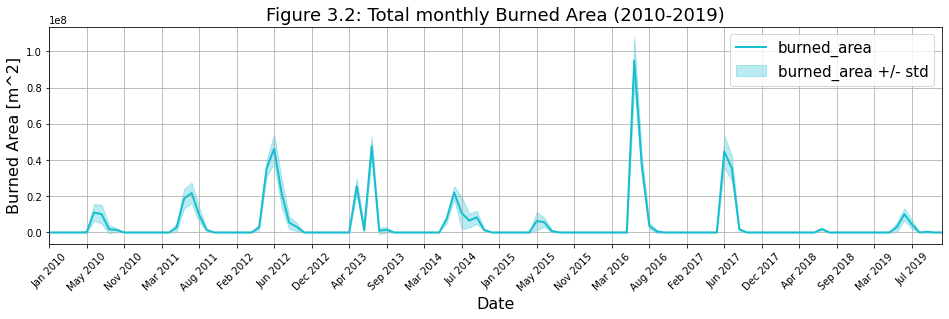

In [3]:
# cut first year from data
for key in data.keys():
    if key not in ["lon","lat"]:
        # lazy cutting since the data is of different shape
        try:
            data[key] = data[key][12:, :, :]
        except:
            data[key] = data[key][12:]

# lets calculate the monthly and yearly bins of the whole island
n_time = data["idx"].shape[0]
monthly_burned_area = np.asarray([np.sum(data["burned_area"][i, :, :]) for i in range(n_time)])
monthly_burned_area_std = np.asarray([np.sum(data["standard_error"][i, :, :]) for i in range(n_time)])
labels = [f"{calendar.month_abbr[m]} {y}" for m,y in zip(data["month"],data["year"])]

plt.figure(figsize=(16,4))
plt.plot(monthly_burned_area,
         'tab:cyan',
        label = "burned_area",
        lw=2)
plt.gca().fill_between(np.arange(monthly_burned_area.shape[0]), 
                       monthly_burned_area - monthly_burned_area_std, 
                       monthly_burned_area + monthly_burned_area_std,
                       color='tab:cyan',
                       alpha = 0.3,
                       label = "burned_area +/- std")
plt.xlim([0,monthly_burned_area.shape[0]-1])
ticks = np.linspace(0, len(labels), num=24, endpoint=False).astype('int')
labels = np.array(labels)
plt.xlim([0,len(labels)-1])
plt.xticks(ticks, labels[ticks], rotation=45)
plt.legend(fontsize=15)
plt.grid()
plt.title("Figure 3.2: Total monthly Burned Area (2010-2019)", fontsize=18)
plt.xlabel("Date", fontsize=16)
_ = plt.ylabel('Burned Area [m^2]', fontsize=16)

**Figure 3.2** clearly shows that there is some kind of seasonality related to wildfires. This seems obvious as in the summer months we expect more heat, less rain and dryer vegetation in general. Given the standard error of the burned area estimation, we see that the data gets more uncertain in regions of high activity. We are able to visualize these fire seasons by summing up our fire data over the respective month.

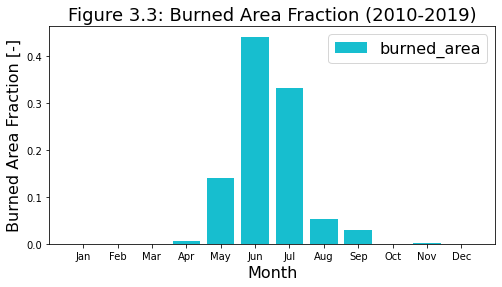

In [4]:
bins = [0 for i in range(12)]

for idx, month in enumerate(data["month"]):
    bins[month-1] += np.sum(data["burned_area"][idx, :, :])
    
plt.figure(figsize=(8,4))
# plt.grid()
x = np.arange(12)
plt.bar(x, bins/np.sum(bins), width=0.8, color="tab:cyan", label="burned_area")
plt.xticks(x, [calendar.month_abbr[t+1] for t in x])
plt.xlabel("Month",fontsize=16)
plt.ylabel("Burned Area Fraction [-]",fontsize=16)
plt.title("Figure 3.3: Burned Area Fraction (2010-2019)", fontsize=18)
_= plt.legend(fontsize=16)

As seen in **Figure 3.3** fires are most prominent during the summer months, which is something one may find obvious. However, it is a good indicator that our data ingress is working well and the data seems plausible on first sight.

Finally let's check which region of Sardinia is the most active in terms of wildfire in the past decade before 2019.

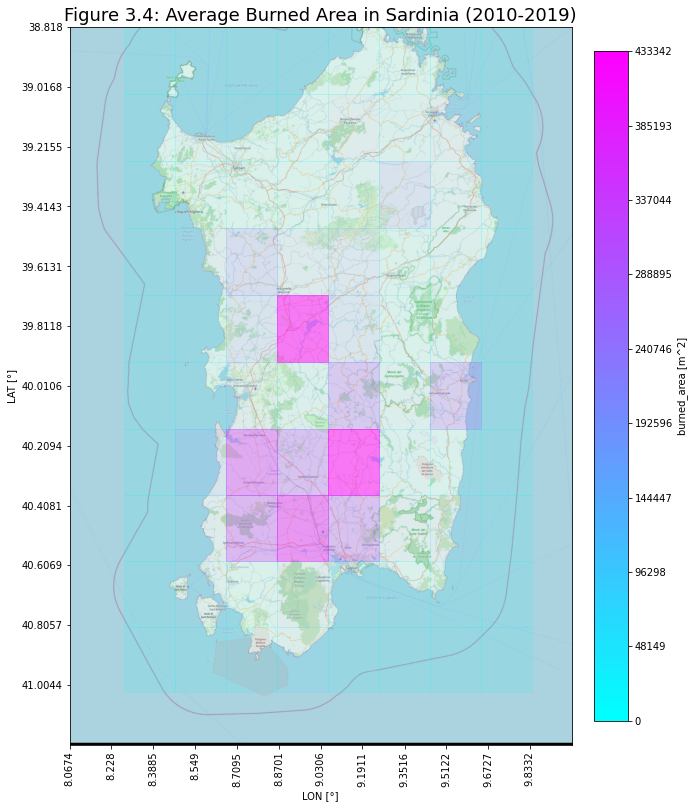

In [5]:
import sys
sys.path.append("../lib")
from OSMPlotter import OSMPlotter
import matplotlib.pyplot as plt

plotter = OSMPlotter(zoom=10)
plotter.plotBaseMap(region="../data/sardinia.shp", figsize=(10,16))
plotter.plotData(data,
                 "burned_area",
                 colormap="cool",
                 compression_mode="mean",
                 alpha=0.5,
                 alpha_by_value=True,
                 cmap_suffix = " [m^2]")
_ = plt.title("Figure 3.4: Average Burned Area in Sardinia (2010-2019)", fontsize=18)

If we visualize the amount of area by region (as seen in **Figure 3.4**), it seems that the southern part and particularly the south-west of Sardinia attains the most fires.

## 3.2 Climate in Sardinia

The ERA5 dataset provides us with an enourmous amount of environmental data, which we are able to explore. Before we proceed with the analysis, I want to take the opportunity to further refine a few variables.

The average windspeed is given at 10m height and split in two components, u and v. Since I do not care for the direction of the wind, I want to merge these two variables into their total magnitude using a simple L2-norm.

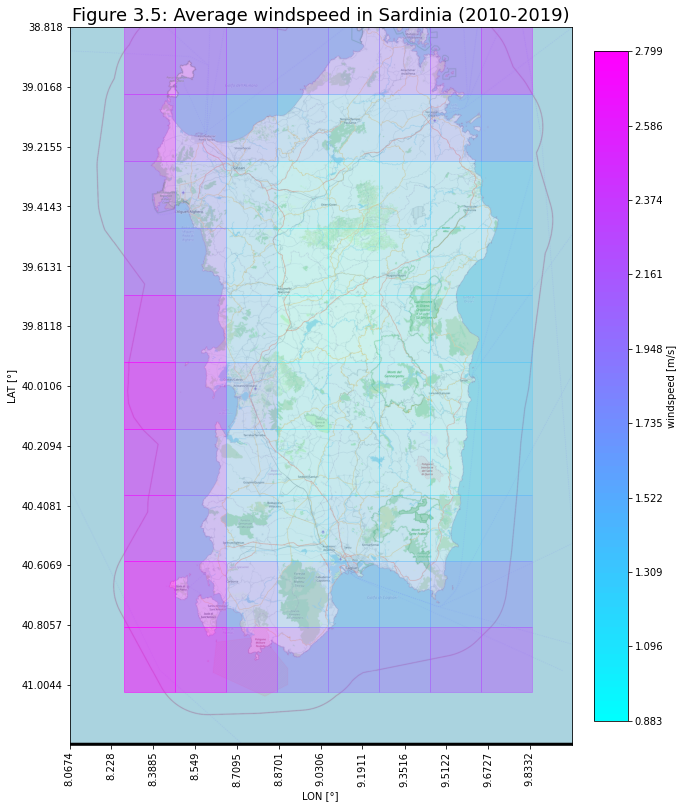

In [6]:
def l2(x,y):
    return np.sqrt(np.power(x,2)+np.power(y,2))

# calculate wind magnitude
n_time = data["idx"].shape[0]
windspeed = [l2(data["u10"][i,:,:],data["v10"][i,:,:]) for i in range(n_time)]
data["windspeed"] = np.asarray(windspeed)

plotter = OSMPlotter(zoom=10)
plotter.plotBaseMap(region="../data/sardinia.shp", figsize=(10,16))
plotter.plotData(data,
                 "windspeed",
                 colormap="cool",
                 alpha=0.5,
                 alpha_by_value=True,
                 compression_mode="mean",
                 cmap_suffix = " [m/s]")
_ = plt.title("Figure 3.5: Average windspeed in Sardinia (2010-2019)", fontsize=18)

**Figure 3.5** shows that the average windspeed offshore is much greater, especially in the western part of the island. Within the island there are only moderate windspeeds on average.

In [7]:
# lets convert the temperatures to degrees celcius
data["skt"] -= 273.15
data["t2m"] -= 273.15

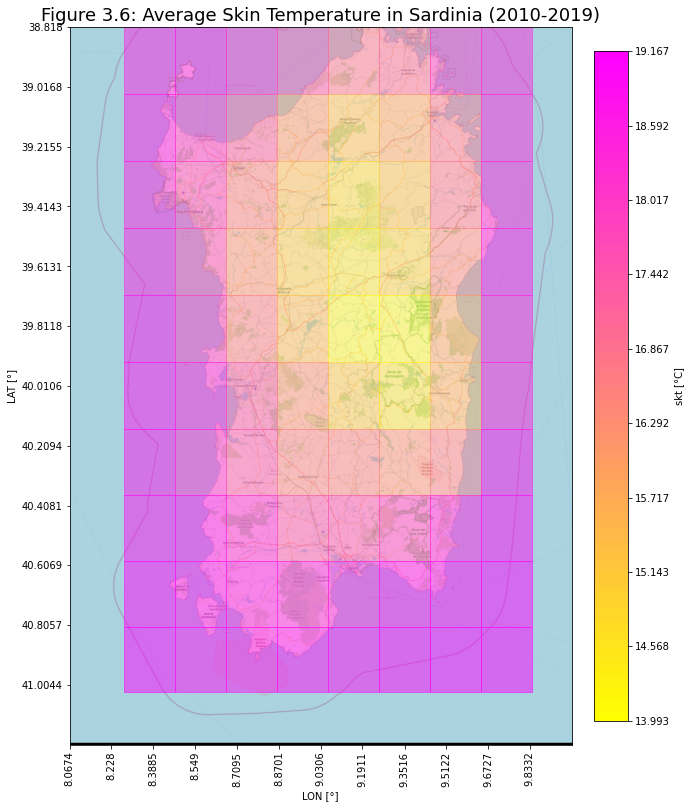

In [8]:
plotter = OSMPlotter(zoom=10)
plotter.plotBaseMap(region="../data/sardinia.shp", figsize=(10,16))
plotter.plotData(data,
                 "skt",
                 colormap="spring_r",
                 alpha=0.5,
                 alpha_by_value=True,
                 compression_mode="mean",
                 cmap_suffix = " [°C]")
_ = plt.title("Figure 3.6: Average Skin Temperature in Sardinia (2010-2019)", fontsize=18)

Interesting, seems like the surface of island itself is cooler than the surrounding water (**Figure 3.6**).

In [9]:
# and the precipitation to mm
data["tp"] = data["tp"] * 1000

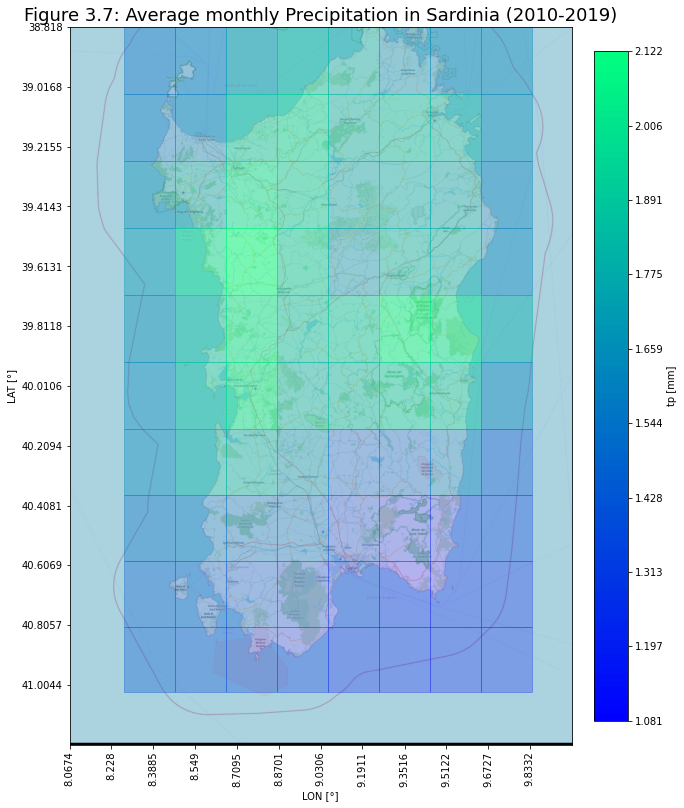

In [10]:
plotter = OSMPlotter(zoom=10)
plotter.plotBaseMap(region="../data/sardinia.shp", figsize=(10,16))
plotter.plotData(data,
                 "tp",
                 colormap="winter",
                 alpha=0.5,
                 alpha_by_value=True,
                 compression_mode="mean",
                 cmap_suffix = " [mm]")
_ = plt.title("Figure 3.7: Average monthly Precipitation in Sardinia (2010-2019)", fontsize=18)

Clearly, it seems that the island is not completely homogenously hit by rain (**Figure 3.7**). I also wonder if there are any events of particularly heavy rain falls. Let's see.

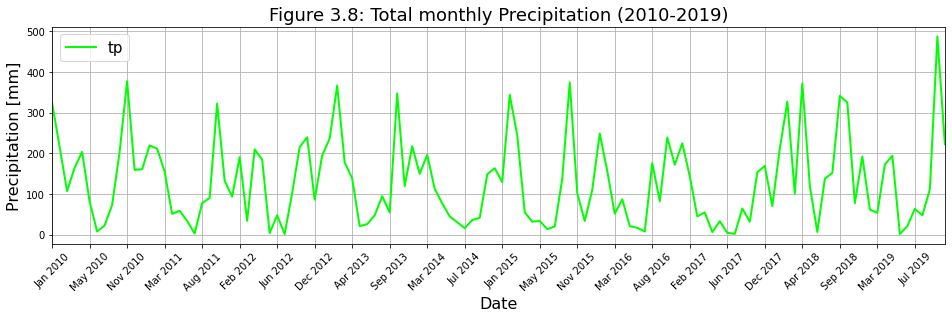

In [11]:
n_time = data["idx"].shape[0]
monthly_tp = np.asarray([np.sum(data["tp"][idx, :, :]) for idx in range(n_time)])
labels = [f"{calendar.month_abbr[m]} {y}" for m,y in zip(data["month"],data["year"])]

plt.figure(figsize=(16,4))
plt.plot(monthly_tp,
         'lime',
        label = "tp",
        lw=2)
plt.xlim([0,monthly_tp.shape[0]-1])
ticks = np.linspace(0, len(labels), num=24, endpoint=False).astype('int')
labels = np.array(labels)
plt.xlim([0,len(labels)-1])
plt.xticks(ticks, labels[ticks], rotation=45)
plt.legend(fontsize=15)
plt.grid()
plt.title("Figure 3.8: Total monthly Precipitation (2010-2019)", fontsize=18)
plt.xlabel("Date", fontsize=16)
_ = plt.ylabel('Precipitation [mm]', fontsize=16)

Well, at least in the monthly average (**Figure 3.8**) it does not seem as if there are any outliers visible.

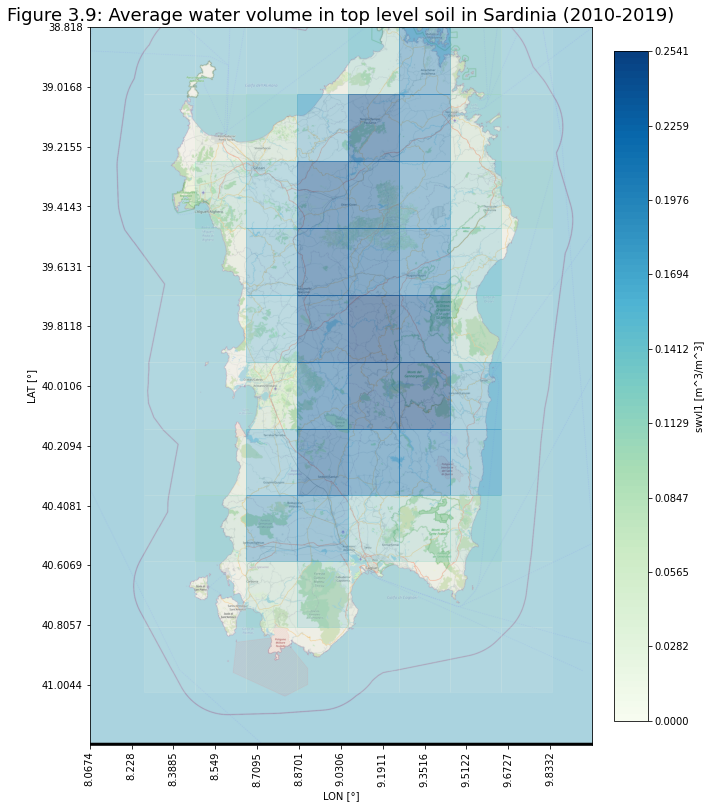

In [12]:
plotter = OSMPlotter(zoom=10)
plotter.plotBaseMap(region="../data/sardinia.shp", figsize=(10,16))
plotter.plotData(data,
                 "swvl1",
                 colormap="GnBu",
                 alpha=0.5,
                 alpha_by_value=True,
                 compression_mode="mean",
                 cmap_suffix = " [m^3/m^3]")
_ = plt.title("Figure 3.9: Average water volume in top level soil in Sardinia (2010-2019)", fontsize=18)

Wow, this is unexpected. Seems like the coastal areas are much dryer than the inner part of the island (**Figure 3.9**)

## 3.3 Moving on

Great, we have explored some of the data that we acquired and it seems there is a lot of entropy hidden in our dataset. The dataset is already we high dimensional, so it could be a good idea to try out a few dimensionality reduction techniques to see if we can make correlations more visible.

For now let's save the changes that we made to our dataset and move on to the hypotheses.

In [13]:
with open("../data/all_data_processed.pkl", "wb") as datafile:
    pickle.dump(data, datafile)